In [11]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import pearsonr
from sklearn.svm import LinearSVR
from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [2]:
# read data & histogram of LoS
data=pd.read_csv("CSV_files/AF_ablation_predictions.CSV", sep=';')

In [3]:
# ===== Feature engineering =====#
# select 33 features
XY = data.iloc[:,[2] + range(6,10) + [12] + range(21,49)]
Y = XY.iloc[:,0] #  LoS
X = XY.iloc[:,1:] # 33 features (all the rest)
key_core = XY.keys()

# change string ==> number feature
ce_ord = ce.OrdinalEncoder(cols = ['Aufnahmewochentag','Geschlecht'])
XY_num = ce_ord.fit_transform(XY)

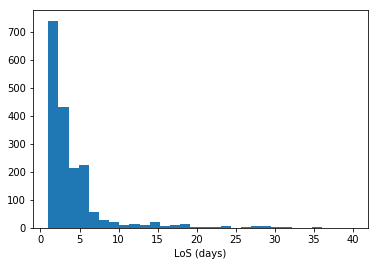

In [4]:
# ===== LoS distribution =====#
plt.figure()
plt.hist(XY_num['LoS'],bins=30)
plt.xlabel('LoS (days)')
plt.show()

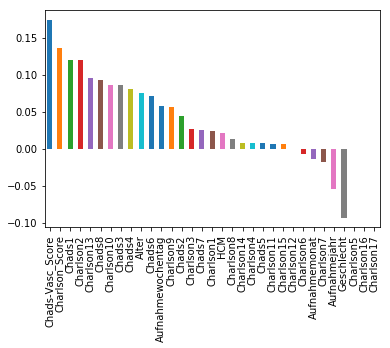

In [5]:
# ===== Simplest correlation check  ===== #
XY_allcorr = XY_num.corr()
corr_result = XY_allcorr['LoS'].sort_values(ascending=False)
plt.figure()
corr_result[1:].plot(kind='bar')

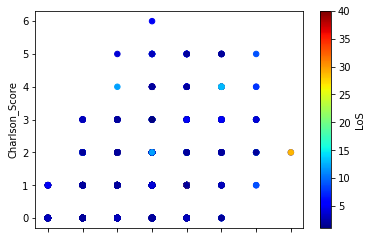

In [7]:
# remove outlier
# XY_new = XY_num[XY_num['LoS']<30]
XY_new = XY_num
# plot the most important feature to determine LoS
XY_new.plot(kind='scatter', x = 'Chads-Vasc_Score', y = 'Charlson_Score', c='LoS',s=30, cmap='jet')
plt.xlabel('Chads-Vasc_Score')
plt.ylabel('Charlson_Score')
plt.show()

In [8]:
#== Add Length of stay (LoS predict) (shorter than 4 days:1, equal or longer than 4 days:0)
XY_new['LoS predict'] = (XY_new.iloc[:,0]<4).astype(int)

# X: 33 features, Y: LoS predict
X_feat = XY_new.iloc[:,1:-1] # exclude LoS & LoS predict column
Y_feat = XY_new.iloc[:,-1] # 1, 0


In [9]:
#=============== logistic regression (machine learning) =====================================#

# split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_feat,Y_feat,test_size=0.2)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# cross-validate
accuracy_scores = cross_val_score(log_reg, X_train, y_train, cv = 5)
accuracy_scores
y_pred=log_reg.predict(X_test)
print(accuracy_scores)


[0.66101695 0.65084746 0.62033898 0.60677966 0.70989761]


/Users/soyoung/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


['Chads8', 'Charlson_Score', 'Chads-Vasc_Score', 'Chads1', 'Charlson2']


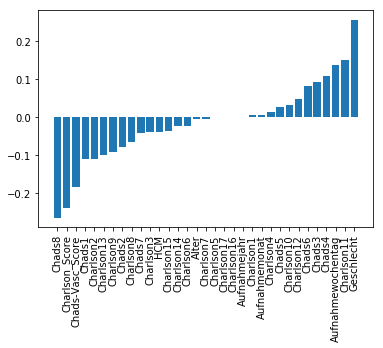

In [12]:
# ===== Important feature sort ===== #
# all feature sort
indx_sort_raw = log_reg.coef_.argsort()
indx_sort = indx_sort_raw[:,:].flatten()
name_sort = list(X_feat.iloc[:,indx_sort])

# top 5 features print
indx_most = indx_sort_raw[:,:5].flatten()
name_most = list(X_feat.iloc[:,indx_most])
print(name_most)
plt.bar(np.arange(33),log_reg.coef_[:,indx_sort].squeeze())
plt.xticks(np.arange(33),name_sort, rotation='vertical')
plt.show()
